<a href="https://colab.research.google.com/github/Tavo826/DataScience/blob/main/ImageCaptionGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta tarea envuelve la visión artificial (CNN) y el procesamiento natural del lenguaje (LSTM - Long Short Term Memory) para reconocer el contexto de una imagen y describirlo en un lenguaje natural

Las características de la imagen se extraen con Xception, que es una red neuronal convolucional entrenada con el conjunto de datos **Imagenet** y luego estas se pasan al modelo LSTM que es el responsable de generar el contexto de la imagen

### Dataset

Se usa el conjunto de datos Flickr_8K que es pequeño comparado con otros.

Flicker8k_Dataset es una carpeta que contiene 8091 imágenes

El Flickr_8K_text contiene el archivo Flickr8k.token que contiene el nombre de la imagen y su respectivo contexto separado por ("\n")

## LSTM (Long Short Memory)

Es un tipo de RNN (Recurrent Neural Network) adecuado para los problemas de predicción de sequencia. Esta puede contener información relevante a los largo del procesamiento y descartar información no relevante



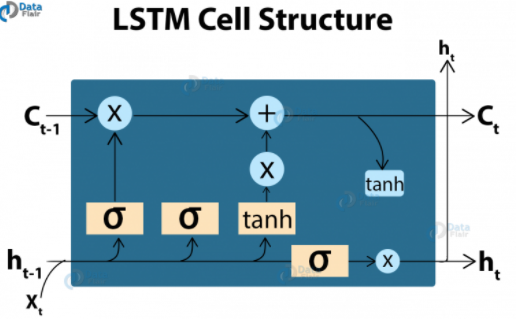

In [ ]:
import os
import tensorflow as tf
from IPython.display import Image

os.chdir('/content/drive/MyDrive/Colab Notebooks/Data Science/Generar la leyenda de una imagen')
Image('LSTM structure.PNG', width=300)

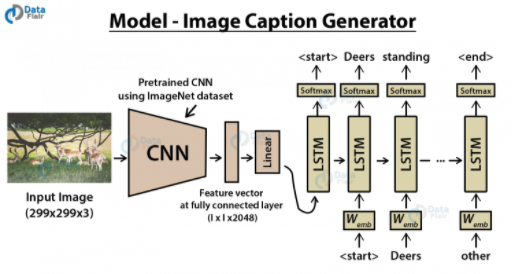

In [ ]:
Image('Model structure.PNG', width=400)

In [ ]:
import string
import numpy as np

from PIL import Image
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

#Para ver el progreso de los bucles
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]


### Análisis exploratorio

El archivo de texto Flickr8k.token contiene el contexto de las imágenes

In [ ]:
file = open('Flickr8k.token.txt', 'r')
lines = file.readlines()
print('Total de líneas: ', len(lines))
#imprimiendo las primeras 10 líneas
for line in lines[:10]:
  print(line)

Total de líneas:  40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .

1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .



Cada imagen tiene contiene 5 descripciones #(0-4)




### Funciones

In [ ]:
# Cargar un archivo de texto en la memoria
def load_doc(filename):
  #Se carga el archivo
  file = open(filename, 'r')
  #Se lee el contenido en una cadena
  text = file.read()
  file.close()
  
  return text

# Obtener todas las imágenes con sus descripciones
def all_img_captions(filename):
  #Crea un diccionario con cada imagen y sus 5 descripciones
  file = load_doc(filename)
  captions = file.split('\n')
  descriptions = {}
  for caption in captions[:-1]:
    img, caption = caption.split('\t')
    if img[:-2] not in descriptions:
      descriptions[img[:-2]] = [caption]
    else:
      descriptions[img[:-2]].append(caption)
  
  return descriptions

#Limpieza de datos, mayúsculas y minúsculas, eliminación de puntuación y palabras con números
def cleaning_text(captions):
  #método para mapear caracteres
  table = str.maketrans('','',string.punctuation)
  for img, caps in captions.items():
    for i, img_caption in enumerate(caps):

      img_caption.replace('-',' ')
      desc = img_caption.split()

      #convirtiendo a minúsculas
      desc = [word.lower() for word in desc]
      #removiendo puntuación
      desc = [word.translate(table) for word in desc]
      #removiendo ' y a
      desc = [word for word in desc if(len(word)>1)]
      #removiendo palabras con números en ellas
      desc = [word for word in desc if(word.isalpha())]

      img_caption = ' '.join(desc)
      captions[img][i] = img_caption
  
  return captions

def text_vocabulary(descriptions):
  #Separa todas las palabras únicas y crea el vocabulario de las descripciones
  vocab = set()
  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]

  return vocab

# Todas las descripciones en un documento
def save_descriptions(descriptions, filename):
  #Crea una lista de todas las descripciones preprocesadas
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + '\t' + desc)
  #Se crea un archivo desciptions.txt para guardar las descripciones
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

dataset_images = 'Flicker8k_Dataset'
filename = 'Flickr8k.token.txt'
#cargando el archivo que contiene los datos
#mapeando los datos en el diccionario de descripciones 
descriptions = all_img_captions(filename)
print('Length of descriptions: ', len(descriptions))

#Limpiando las descripciones
clean_descriptions = cleaning_text(descriptions)

#Construyendo el vocabulario
vocabulary = text_vocabulary(clean_descriptions)
print('Length of vocabulary: ', len(vocabulary))

#Guardando cada descripción en un archivo
save_descriptions(clean_descriptions, 'descriptions.txt')

Length of descriptions:  8092
Length of vocabulary:  8763


### Extrayendo el vector de características de todas las imágenes (Transfer Learning)

Se usa un modelo pre-entrenado llamado Xception, el cual contiene 1000 clases diferentes para clasificar.

Este modelo toma imágenes de tamaño (299,299,3), para este caso se remueve la última capa de clasificación y se obtiene el vector de características de 2048

In [ ]:
def extrac_features(directory):
  model = Xception(include_top=False, pooling='avg')
  features = {}
  for img in tqdm(os.listdir(directory)):
    filename = directory + '/' + img
    image = Image.open(filename)
    image = image.resize((299,299))
    image = np.expand_dims(image, axis=0)
    image = image / 255
    image = image - 1.0
    
    feature = model.predict(image)
    features[img] = feature
  
  return features

features = extrac_features(dataset_images)
dump(features, open('features.p', 'wb'))

83689472/83683744 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [2:16:52<00:00,  1.02s/it]


### Cargando el conjunto de datos para entrenar el modelo

In [ ]:
def load_photos(filename):
  #Carga el archivo de texto en una cadena
  file = load_doc(filename)
  #Retorna la lista con el nombre de las imágenes
  photos = file.split('\n')[:-1]
  
  return photos

def load_clean_descriptions(filename, photos):
  #Crea un diccionario que contiene las descripciones de cada foto
  #Se agregan los identificadores <start> y <end> para cada descripción
  file = load_doc(filename)
  descriptions = {}
  
  for line in file.split('\n'):
    words = line.split()
    if len(words) < 1:
      continue

    image, image_caption = words[0], words[1:]

    if image in photos:
      if image not in descriptions:
        descriptions[image] = []
      desc = '<start> ' + ' '.join(image_caption) + ' <end>'
      descriptions[image].append(desc)
  
  return descriptions

def load_features(photos):
  #Retorna el diccionario para cada nombre de la imagen su vector de características extraído de Xception
  all_features = load(open('features.p', 'rb'))
  features = {k:all_features[k] for k in photos}

  return features

filename = 'Flickr_8k.trainImages.txt'

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

### Tokenizando el vocabulario

Se mapea cada palabra con un único valor indexado

In [ ]:
#Convirtiendo el diccionario a una lista de descripciones
def dict_to_list(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  
  return all_desc

#Creando la clase tokenizadora
#Se vectoriza el cuerpo del texto, cada entero representa el token en el diccionario

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
  desc_list = dict_to_list(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(desc_list)

  return tokenizer

#Se le da a cada palabra un token y se guarda en un archivo
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocab_size: ', vocab_size)

Vocab_size:  7577


In [ ]:
#Calculando la longitud máxima de las descripciones para decidir la estructura de los parámetros del modelo
def max_length(descriptions):
  desc_list = dict_to_list(descriptions)
  return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
print('Max_length: ', max_length)

Max_length:  32


### Creando el generador de datos

Se debe entrenar el modelo sobre 6000 imágenes y cada imagen contiene un vector de características de tamaño 2048 y la descripcióntambién se representa como números. Como el número de imágenes desborda la memoria se crea un generador que produce lotes

Por ejempo, la entrada del modelo es [x1,x2] y la salida es y, donde x1 es el vector de características (2048) de esa imagen, x2 es la secuencia de entrada de texto, y es la secuencia de salida de texto que el modelo predice

In [ ]:
import pandas as pd

df = pd.DataFrame({'x1(feature vector)': ['feature', 
                                        'feature', 
                                        'feature', 
                                        'feature', 
                                        'feature'],
                   'x2(Text sequence)': ['start',
                                       'start, two',
                                       'start, two, dogs',
                                       'start, two, dogs, drink',
                                       'start, two, dogs, drink, water'],
                   'y(word to predict)': ['two',
                                        'dogs',
                                        'drink',
                                        'water',
                                        'end']})

df

,x1(feature vector),x2(Text sequence),y(word to predict)
0,feature,start,two
1,feature,"start, two",dogs
2,feature,"start, two, dogs",drink
3,feature,"start, two, dogs, drink",water
4,feature,"start, two, dogs, drink, water",end


In [ ]:
#Creando los pares de secuencia de entrada y salida de la descripción de la imagen

# generator = data_generator(train_descriptions,
#                             train_features,
#                             tokenizer,
#                             max_length)

def data_generator(descriptions, features, tokenizer, max_length):
  while True:
    for key, description_list in descriptions.items():
      #Recuperando la característica de la foto
      feature = features[key][0]
      input_image, input_sequence, output_word = create_sequences(tokenizer, 
                                                                  max_length,
                                                                  description_list,
                                                                  feature)
      yield [[input_image, input_sequence[:,0,:]], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
  X1, X2, y = [], [], []
  #Recorriendeo cada descripción de la imagen
  for desc in desc_list:
    #Decodificando la secuencia
    seq = tokenizer.texts_to_sequences([desc])[0]
    #Dividiendo los pares de entrada y salida
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      #Secuencia de entrada
      in_seq = pad_sequences([in_seq], maxlen=max_length)

      #Codificando la secuencua de salida
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      #Guardando
      X1.append(feature)
      X2.append(in_seq)
      y.append(out_seq)
  
  return np.array(X1), np.array(X2), np.array(y)

#Tamaño de la entrada y la salida para el modelo
[a,b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))

print('Input image shape: ', a.shape)
print('Input sequence shape: ', b.shape)
print('Output word shape: ', c.shape)

Input image shape:  (47, 2048)
Input sequence shape:  (47, 32)
Output word shape:  (47, 7577)


### Definiendo el modelo CNN-RNN

**Extracción de características:** tiene tamaño 2048 con una capa densa para reducir la dimensión a 256 nodos

**Procesador de secuencia:** una capa de incrustación maneja la entrada textual, seguida de la capa LSTM

**Decodificador:** fusionando la salida de las dos capas anteriores, se procesa por la capa densa realizando la predicción final. La capa final tendrá el número de nodos igual al tamaño del vocabulario

In [ ]:
from keras.utils import plot_model

def define_model(vocab_size, max_length):
  
  #Características del modelo CNN pasando de 2048 a 256 nodos
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)

  #Modelo sequencial LSTM
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)

  #Fusionando los 2 modelos
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  #Uniendo [image, seq] [word]
  model = Model(inputs=[inputs1,inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')

  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)

  return model

### Entrenando el modelo

Se usan 6000 imágenes generando las secuencias de entradas y salidas en batches

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary size: ', vocab_size)
print('Description Length: ', max_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary size:  7577
Description Length:  32


In [ ]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)

#Guardando el modelo

if not os.path.isdir('models'):
  os.mkdir('models')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 32, 256)      1939712     input_17[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 2048)         0           input_16[0][0]                   
____________________________________________________________________________________________

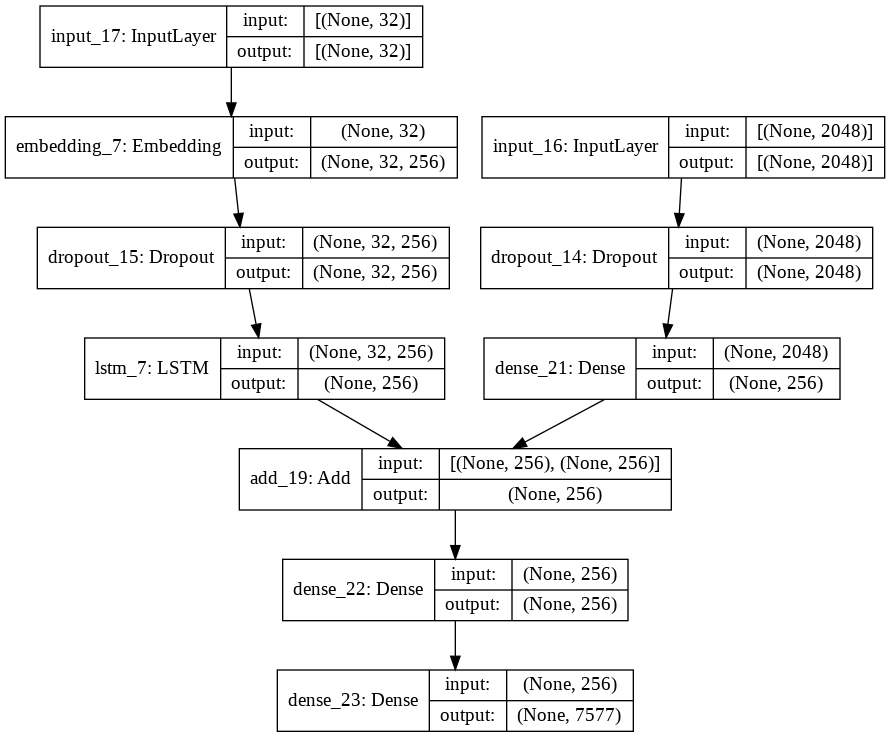

In [ ]:
from IPython.display import Image
Image('model.png', width=500)

In [ ]:
for i in range(epochs):
  generator = data_generator(train_descriptions,
                             train_features,
                             tokenizer,
                             max_length)
  
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  model.save('models/model_' + str(i) + '.h5')

Paso:  0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ValueError: ignored

### Probando el modelo

Las predicciones contienen la lóngitud máxima de los valores de los índices, luego se usa el archivo tokenizer.p para obtener las palabras del valor del índice

In [ ]:
import matplotlib.pyplot as plt
import argparse

ap = argparse.ArgumentParser()
ap.add_argument('-1', '--image', required=True, help='Image Path')
args = vars(ap.parse_args())
img_path = args['image']

def extract_features(filename, model):
  
  try:
    image = Image.open(filename)
  except:
    print("ERROR: Couldn't open image")
  
  image = image.resize((299,299))
  image = np.aray(image)
  
  #Asegurándose que las imágenes tengan 3 canales
  if image.shape[2] == 4:
    image = image[..., :3]
  
  image = np.expand_dims(image, axis=0)
  image = image / 127.5
  image = image - 1.0
  feature = model.predict(image)
  
  return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word

  return None

def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'start'
  for i in range(max_length):
    sequence = tokenizer.text_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    pred = model.predict([photo,sequence], verbose=0)
    pred = np.argmax(pred)
    word = word_for_id(pred, tokenizer)
    if word is None:
      break
    in_text += ' ' + word
    if word == 'end':
      break
  
  return in_text

max_length = 32
tokenizer = load(open('tokenizer.p', 'rb'))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling='avg')

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print('\n\n')
print(descrption)
plt.imshow(img)